# Flowers image classification

## Importing required modules

In [2]:
import os 
import torch
import torchvision
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

## Preparing the data

In [3]:
TRAIN_DIR = "../input/104-flowers-garden-of-eden/jpeg-224x224/train"
VAL_DIR = "../input/104-flowers-garden-of-eden/jpeg-224x224/val"

In [4]:
transform_train = T.Compose([
    T.RandomCrop(128, padding_mode="reflect"),
    T.RandomHorizontalFlip(),
    T.ToTensor()
])
train_ds = ImageFolder(
    root=TRAIN_DIR,
    transform=transform_train
)

In [5]:
transform_val = T.Compose([
    T.ToTensor()
])

val_ds = ImageFolder(
    root=VAL_DIR,
    transform=transform_val

)

In [6]:
batch_size=128

The data loader will allow to access the data in batches.

In [7]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=3, pin_memory=True)

This is a helper method to show a batch of images and make sure that everything is working.

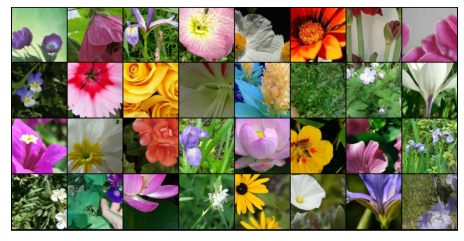

In [7]:
def show_batch(train_dl):
    for images,_ in train_dl:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1,2,0))
        break
        
show_batch(train_dl)

## Moving to the GPU

    The following code will be used to make sure a GPU is being used

In [8]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda") #if the GPU is availble this method will return cuda.
    else:
        return torch.device("cpu")
    
def to_device(data, device): #in here we move the data to device of our choice, the GPU
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)
            
    def __len__(self):
        return len(self.dl)
    
device = get_device()
device

device(type='cuda')

## The model

In [9]:
def accuracy(out, labels):
    _, preds = torch.max(out, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out =self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {"val_loss": loss.detach(), "val_acc": acc}
    
    def validation_epoch_end(self, outputs):
        batch_loss = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}
    
    def epoch_end(self, epoch, epochs, result):
        print("Epoch: [{}/{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch+1, epochs, result["lrs"][-1], result["train_loss"], result["val_loss"], result["val_acc"]))

In [10]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet34(pretrained=True)
        number_of_features = self.network.fc.in_features
        self.network.fc = nn.Linear(number_of_features, 104)
        
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self): #by freezing all the layers but the last one we allow it to warm up (the others are already good at training)
        for param in self.network.parameters():
            param.require_grad=False
        for param in self.network.fc.parameters():
            param.require_grad=True
            
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad=True

In [11]:
model = ResNet()
model

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [12]:
model = to_device(model, device) #let's move the model to the GPU

In [13]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [14]:
@torch.no_grad()
def evaluate(model, val_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]
    
def fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, weight_decay=0,
                 grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    
    history = []
    opt = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr, epochs=epochs,
                                               steps_per_epoch=len(train_dl))
    
    for epoch in range(epochs):
        model.train()
        train_loss = []
        lrs = []
        for batch in tqdm(train_dl):
            loss = model.training_step(batch)
            train_loss.append(loss)
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            opt.step()
            opt.zero_grad()
            
            lrs.append(get_lr(opt))
            sched.step()
            
        result = evaluate(model, val_dl)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, epochs, result)
        history.append(result)
    return history

In [15]:
result = evaluate(model, val_dl) #let's check the model performance before training it
result

{'val_loss': 5.001692295074463, 'val_acc': 0.00754310330376029}

In [35]:
model.freeze()

In [16]:
epochs = 10
max_lr = 10e-4
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [17]:
%%time

history = fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                       weight_decay=weight_decay, grad_clip=grad_clip,
                       opt_func=opt_func)


Epoch: [1/10], last_lr: 0.0003, train_loss: 2.9544, val_loss: 1.8016, val_acc: 0.7004



Epoch: [2/10], last_lr: 0.0008, train_loss: 1.2829, val_loss: 2.5816, val_acc: 0.3809



Epoch: [3/10], last_lr: 0.0010, train_loss: 1.2759, val_loss: 2.1262, val_acc: 0.4763



Epoch: [4/10], last_lr: 0.0010, train_loss: 1.0506, val_loss: 1.2115, val_acc: 0.6783



Epoch: [5/10], last_lr: 0.0008, train_loss: 0.8416, val_loss: 0.9691, val_acc: 0.7468



Epoch: [6/10], last_lr: 0.0006, train_loss: 0.6368, val_loss: 0.7036, val_acc: 0.8238



Epoch: [7/10], last_lr: 0.0004, train_loss: 0.4565, val_loss: 0.5624, val_acc: 0.8551



Epoch: [8/10], last_lr: 0.0002, train_loss: 0.3420, val_loss: 0.4537, val_acc: 0.8869



Epoch: [9/10], last_lr: 0.0000, train_loss: 0.2347, val_loss: 0.4187, val_acc: 0.8960



Epoch: [10/10], last_lr: 0.0000, train_loss: 0.1993, val_loss: 0.4153, val_acc: 0.8957
CPU times: user 1min 32s, sys: 32.2 s, total: 2min 4s
Wall time: 7min 8s


In [18]:
model.unfreeze()

In [19]:
epochs = 10
max_lr = 0.0005
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [20]:
%%time

history = fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                       weight_decay=weight_decay, grad_clip=grad_clip,
                       opt_func=opt_func)


Epoch: [1/10], last_lr: 0.0001, train_loss: 0.2021, val_loss: 0.4396, val_acc: 0.8866



Epoch: [2/10], last_lr: 0.0004, train_loss: 0.3053, val_loss: 0.6576, val_acc: 0.8314



Epoch: [3/10], last_lr: 0.0005, train_loss: 0.5574, val_loss: 0.9944, val_acc: 0.7454



Epoch: [4/10], last_lr: 0.0005, train_loss: 0.5267, val_loss: 0.7773, val_acc: 0.7950



Epoch: [5/10], last_lr: 0.0004, train_loss: 0.3958, val_loss: 0.5961, val_acc: 0.8435



Epoch: [6/10], last_lr: 0.0003, train_loss: 0.3123, val_loss: 0.5434, val_acc: 0.8607



Epoch: [7/10], last_lr: 0.0002, train_loss: 0.2196, val_loss: 0.4754, val_acc: 0.8831



Epoch: [8/10], last_lr: 0.0001, train_loss: 0.1465, val_loss: 0.4347, val_acc: 0.8901



Epoch: [9/10], last_lr: 0.0000, train_loss: 0.1118, val_loss: 0.4124, val_acc: 0.8957



Epoch: [10/10], last_lr: 0.0000, train_loss: 0.0945, val_loss: 0.4136, val_acc: 0.8963
CPU times: user 1min 30s, sys: 30.8 s, total: 2min 1s
Wall time: 7min 2s


## Model performance

Text(0, 0.5, 'Loss')

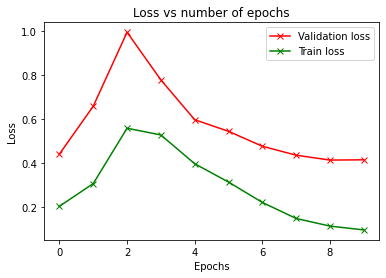

In [21]:
val_loss = [x["val_loss"] for x in history]
train_loss = [x.get("train_loss") for x in history]
plt.plot(val_loss, "-rx")
plt.plot(train_loss, "-gx")
plt.title("Loss vs number of epochs")
plt.legend(["Validation loss", "Train loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

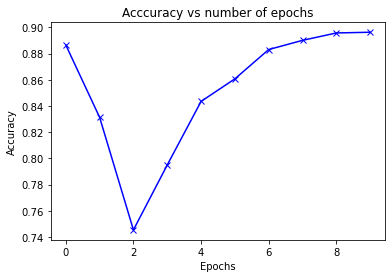

In [22]:
accuracy = [x["val_acc"] for x in history]
plt.plot(accuracy, "-bx")
plt.title("Acccuracy vs number of epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

## Predictions

In [23]:
import pandas as pd
from torch.utils.data import Dataset
from torchvision.datasets.folder import default_loader

In [24]:
df = pd.read_csv("../input/flowers/flowers")
df.head()

,id,label
0,252d840db,67
1,1c4736dea,28
2,c37a6f3e9,103
3,00e4f514e,103
4,59d1b6146,53


In [25]:
class TestData(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.label = pd.read_csv(csv_file)
        self.transform = transform
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.item()
        
        label = self.label.iloc[idx,1]
        image_path = os.path.join(self.root_dir, f"{self.label.iloc[idx,0]}.jpeg")
        
        image = default_loader(image_path)
        
        if self.transform:
            image = self.transform(image)
        
        return (image, label)

In [26]:
TEST_DIR = "../input/104-flowers-garden-of-eden/jpeg-224x224/test"

In [27]:
transform_test = T.Compose([
    T.ToTensor()
])

test_ds = TestData(
    root_dir=TEST_DIR,
    csv_file="../input/flowers/flowers",
    transform=transform_test

)

In [28]:
def predict_image(image):
    xb = to_device(image.unsqueeze(0), device)
    out = model(xb)
    _, preds = torch.max(out, dim=1)
    prediction = preds[0].item()
    return prediction

Label: 73
Prediction: 44


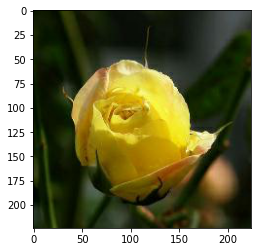

In [31]:
image, label = test_ds[20]
print("Label:", label)
print("Prediction:", predict_image(image))
plt.imshow(image.permute(1,2,0))